## Zmiany danych źrodłowych o sprzedaży

In [1]:
import numpy as np
import pandas as pd
import requests

In [165]:
sales_df = pd.read_csv('sales_data_sample.csv', encoding='cp1250')

### Uwspółcześnienie dat
Zmiana na daty współczesne (z lat 2003-2005 na 2020-2022).

In [166]:
sales_df['ORDERDATE'] = sales_df['ORDERDATE'].astype("datetime64")

In [167]:
# zakres dat w oryginalnych danych
sales_df['ORDERDATE'].min(), sales_df['ORDERDATE'].max()

(Timestamp('2003-01-06 00:00:00'), Timestamp('2005-05-31 00:00:00'))

In [168]:
# dni tygodnia w oryginalnych danych
# 0 - poniedziałek, 6 - niedziela
# są zarejestrowane sprzedaze we wszystkie, więc mozna po prostu przesunac date 
# bez zwracania uwagi na dni tygodnia
sales_df.ORDERDATE.dt.dayofweek.value_counts()

4    598
2    562
3    538
1    515
0    366
5    123
6    121
Name: ORDERDATE, dtype: int64

In [169]:
sales_df["ORDERDATE"] = sales_df["ORDERDATE"] + pd.offsets.DateOffset(years=17)

In [172]:
# zakres dat w zmienionych danych
sales_df['ORDERDATE'].min(), sales_df['ORDERDATE'].max()

(Timestamp('2020-01-06 00:00:00'), Timestamp('2022-05-31 00:00:00'))

In [174]:
# dni tygodnia w zmienionych danych
# dalej najmniej pozostaje w niedziele - OK
sales_df.ORDERDATE.dt.dayofweek.value_counts()

2    567
4    567
3    535
1    429
5    321
0    305
6     99
Name: ORDERDATE, dtype: int64

In [183]:
sales_df.YEAR_ID = sales_df.ORDERDATE.dt.year
sales_df.QTR_ID = sales_df.ORDERDATE.dt.quarter
sales_df.MONTH_ID = sales_df.ORDERDATE.dt.month

### Zmiany walutowe

#### Zmiana SuggestedRetailPrice na cenę wyrażoną w złotówkach
(oryginalnie prawdopodobnie cena jest w dolarach amerykańskich)

In [115]:
# żeby zachować sugerowaną cenę w intach 
sales_df.MSRP =  sales_df.MSRP * 4 

#### Naprawa przycietej ceny 

<AxesSubplot:>

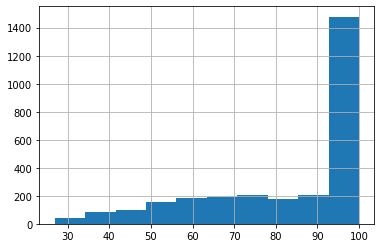

In [177]:
# cena sprzedazy jest przycieta do wartosci 100
sales_df.PRICEEACH.hist()

In [179]:
# przez to nie zgadza sie wyliczenie lacznej kwoty sprzedazy dla 1304 rekordow 
mask = np.abs(sales_df["PRICEEACH"] * sales_df["QUANTITYORDERED"] - sales_df["SALES"]) > 0.01
tmp = sales_df[mask]
tmp.PRICEEACH.value_counts()

100.0    1304
Name: PRICEEACH, dtype: int64

In [118]:
# naprawa
sales_df.loc[mask, "PRICEEACH"] = sales_df.loc[mask, "SALES"] / sales_df.loc[mask, "QUANTITYORDERED"]

In [122]:
# sprawdzenie
np.mean(np.abs(sales_df["PRICEEACH"] * sales_df["QUANTITYORDERED"] - sales_df["SALES"]) < 0.0001)

1.0

#### Zmiana walut na waluty poszczególnych krajów

In [123]:
sales_df["PRICEEACH"] = sales_df["PRICEEACH"] * 4

In [124]:
country_currency_dict = {
    'Australia': "AUD",
    'Austria': "EUR",
    'Belgium': "EUR",
    'Canada': "CAD", 
    'Denmark': "EUR", 
    'Finland': "EUR",
    'France': "EUR", 
    'Germany': "EUR", 
    'Ireland': "EUR", 
    'Italy': "EUR", 
    'Japan': "JPY", 
    'Norway': "NOK",
    'Philippines': "PHP",
    'Singapore': "SGD", 
    'Spain': "EUR", 
    'Sweden': "SEK", 
    'Switzerland': "CHF", 
    'UK': "GBP",
    'USA': "USD"
}

In [125]:
sales_df['CURRENCY'] = sales_df['COUNTRY'].map(country_currency_dict)

In [136]:
API_URL = "http://api.nbp.pl/api/exchangerates/rates/{table}/{code}/{date}/?format=json"
currency_rates = {}
unique_currencies = sales_df['CURRENCY'].unique()
for currency in unique_currencies:
    r = requests.get(API_URL.format(table='a', code=currency, date='2022-05-20'))
    currency_rates[currency] = r.json()["rates"][0]["mid"]

In [143]:
def change_price_to_local_currency(row):
    return np.round(row.PRICEEACH/currency_rates[row.CURRENCY], 2)

In [145]:
sales_df["PRICEEACH"] = sales_df.apply(change_price_to_local_currency, axis=1)

In [147]:
sales_df["SALES"] = sales_df["PRICEEACH"] * sales_df["QUANTITYORDERED"]

In [150]:
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,CURRENCY
0,10107,30,87.33,2,2619.90,2020-02-23,Shipped,1,2,2003,...,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small,USD
1,10121,34,70.18,5,2386.12,2020-05-06,Shipped,2,5,2003,...,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small,EUR
2,10134,41,81.73,2,3350.93,2020-06-30,Shipped,3,7,2003,...,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium,EUR
3,10145,45,75.98,6,3419.10,2020-08-24,Shipped,3,8,2003,...,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium,USD
4,10159,49,96.94,14,4750.06,2020-10-09,Shipped,4,10,2003,...,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,96.81,15,1936.20,2021-12-01,Shipped,4,12,2004,...,NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small,EUR
2819,10373,29,118.35,1,3432.15,2022-01-30,Shipped,1,1,2005,...,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium,EUR
2820,10386,43,108.69,4,4673.67,2022-02-28,Resolved,1,3,2005,...,NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium,EUR
2821,10397,34,53.69,1,1825.46,2022-03-27,Shipped,1,3,2005,...,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small,EUR


In [4]:
sales_df.TERRITORY.unique()

array([nan, 'EMEA', 'APAC', 'Japan'], dtype=object)

In [80]:
sales_df.groupby("ORDERNUMBER")["SALES"].value_counts()

ORDERNUMBER  SALES  
10100        1689.03    1
             1903.22    1
             3390.00    1
             5151.00    1
10101        1404.00    1
                       ..
10425        4325.16    1
             4692.60    1
             5318.04    1
             5510.54    1
             5894.94    1
Name: SALES, Length: 2823, dtype: int64

In [6]:
sales_df.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

In [77]:
sales_df.groupby(["CUSTOMERNAME"])["CONTACTLASTNAME"].nunique().sort_values()

CUSTOMERNAME
AV Stores, Co.                  1
Reims Collectables              1
Quebec Home Shopping Network    1
Petit Auto                      1
Oulu Toy Supplies, Inc.         1
                               ..
Daedalus Designs Imports        1
Cruz & Sons Co.                 1
Corrida Auto Replicas, Ltd      1
Euro Shopping Channel           1
giftsbymail.co.uk               1
Name: CONTACTLASTNAME, Length: 92, dtype: int64

In [36]:
sales_df.groupby(["ORDERNUMBER"])["DEALSIZE"].nunique().sort_values()

ORDERNUMBER
10277    1
10125    1
10128    1
10130    1
10376    1
        ..
10325    3
10324    3
10206    3
10176    3
10151    3
Name: DEALSIZE, Length: 307, dtype: int64

In [19]:
sales_df.groupby(["PRODUCTCODE"])["MSRP"].nunique().sort_values()

PRODUCTCODE
S10_1678    1
S24_3969    1
S24_3949    1
S24_3856    1
S24_3816    1
           ..
S18_2581    1
S18_2432    1
S18_2325    1
S18_3232    1
S72_3212    1
Name: MSRP, Length: 109, dtype: int64

In [24]:
sales_df.PRODUCTLINE.unique()

array(['Motorcycles', 'Classic Cars', 'Trucks and Buses', 'Vintage Cars',
       'Planes', 'Ships', 'Trains'], dtype=object)

In [23]:
sales_df.sort_values("ORDERNUMBER")[["ORDERNUMBER", "ORDERLINENUMBER"]].head(20)

,ORDERNUMBER,ORDERLINENUMBER
578,10100,3
2024,10100,1
680,10100,2
1267,10100,4
728,10101,4
1539,10101,3
830,10101,1
1616,10101,2
475,10102,2
501,10102,1


In [54]:
sales_df.SALES.sum()

10032628.85

In [7]:
sales_df[['QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',  'SALES',   'PRODUCTLINE', 'MSRP', 'PRODUCTCODE',  ]]

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,PRODUCTLINE,MSRP,PRODUCTCODE
0,30,95.70,2,2871.00,Motorcycles,95,S10_1678
1,34,81.35,5,2765.90,Motorcycles,95,S10_1678
2,41,94.74,2,3884.34,Motorcycles,95,S10_1678
3,45,83.26,6,3746.70,Motorcycles,95,S10_1678
4,49,100.00,14,5205.27,Motorcycles,95,S10_1678
...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,Ships,54,S72_3212
2819,29,100.00,1,3978.51,Ships,54,S72_3212
2820,43,100.00,4,5417.57,Ships,54,S72_3212
2821,34,62.24,1,2116.16,Ships,54,S72_3212


In [33]:
np.unique(sales_df['COUNTRY'])

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland',
       'France', 'Germany', 'Ireland', 'Italy', 'Japan', 'Norway',
       'Philippines', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'UK',
       'USA'], dtype=object)

In [14]:
max(sales_df['PRODUCTCODE'].apply(len)), min(sales_df['PRODUCTCODE'].apply(len))

(9, 8)

In [26]:
np.unique(sales_df['STATUS'].apply(len))

array([ 7,  8,  9, 10])

In [28]:
np.unique(sales_df['DEALSIZE'])

array(['Large', 'Medium', 'Small'], dtype=object)

In [8]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


# Wymiary (numery kolumn)
+ Czas (5,7,8,9)
+ Geografia (hierarchia) (15,16,17,18,19,20,21,25)
+ klienci (13,14,15,16,22,23)
+ produkt (10,11,12)

# Fakty
2 tabele faktowe? Czy zmergowane ceny walut do zamówienia
+ Zamówienie (1,2,3,4,6,24)
+ Cena waluty (każdego dnia?/ miesiąca?)


# Częstotliwość odświeżania

In [5]:

min(sales_df['ORDERDATE']), max(sales_df['ORDERDATE'])

(Timestamp('2003-01-06 00:00:00'), Timestamp('2005-05-31 00:00:00'))

In [22]:
sales_df['ORDERDATE'] +  

0      2020-02-24
1      2020-05-07
2      2020-07-01
3      2020-08-25
4      2020-10-10
          ...    
2818   2021-12-02
2819   2022-01-31
2820   2022-03-01
2821   2022-03-28
2822   2022-05-06
Name: ORDERDATE, Length: 2823, dtype: datetime64[ns]

<AxesSubplot:xlabel='ORDERDATE,ORDERDATE'>

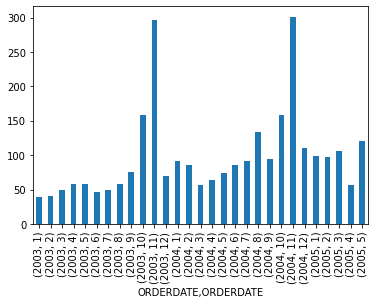

In [38]:
sales_df['ORDERDATE'].groupby([sales_df["ORDERDATE"].dt.year, sales_df["ORDERDATE"].dt.month]).count().plot(kind="bar")

Miesięczna częstotliwość odświeżania wydaje się być ok.

# Join do danych z API NBP

In [127]:
API_URL = "http://api.nbp.pl/api/exchangerates/rates/{table}/{code}/{date}/?format=json"
print(API_URL.format(table='a', code='EUR', date='2003-06-05'))
r = requests.get(API_URL.format(table='a', code='EUR', date='2003-01-06'))
r.json()

http://api.nbp.pl/api/exchangerates/rates/a/EUR/2003-06-05/?format=json


{'table': 'A',
 'country': 'UGW',
 'symbol': '978',
 'code': 'EUR',
 'rates': [{'no': '3/A/NBP/2003',
   'effectiveDate': '2003-01-06',
   'mid': 3.9987}]}

In [12]:
sales_df.iloc[123]['ORDERDATE'].isoformat()[:10]

'2004-11-01'

In [40]:
def get_currency_rate(record):
    date = record['ORDERDATE']
    currency = record['CURRENCY']
    r = requests.get(API_URL.format(table='a', code=currency, date=date.isoformat()[:10]))
    if r.status_code == 200:
        return r.json()
    if r.status_code == 404:
        raise Exception("Got code {status}".format(status=r.status_code))

In [46]:
sales_df.iloc[123]

ORDERNUMBER                             10316
QUANTITYORDERED                            33
PRICEEACH                               100.0
ORDERLINENUMBER                            17
SALES                                 4128.96
ORDERDATE                 2004-11-01 00:00:00
STATUS                                Shipped
QTR_ID                                      4
MONTH_ID                                   11
YEAR_ID                                  2004
PRODUCTLINE                      Classic Cars
MSRP                                      136
PRODUCTCODE                          S10_4757
CUSTOMERNAME                giftsbymail.co.uk
PHONE                          (198) 555-8888
ADDRESSLINE1        Garden House Crowther Way
ADDRESSLINE2                              NaN
CITY                                    Cowes
STATE                           Isle of Wight
POSTALCODE                           PO31 7PJ
COUNTRY                                    UK
TERRITORY                         

In [45]:
get_currency_rate(sales_df.iloc[123])

Exception: Got code 404

In [67]:
not_matched = 0
not_matched_ids = []
for idx, record in sales_df[:100].iterrows():
    try:
        get_currency_rate(record)
    except Exception:
        not_matched += 1
        not_matched_ids.append(record.ORDERDATE)

In [68]:
sales_df.head(25)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,CURRENCY
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small,USD
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small,EUR
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium,EUR
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium,USD
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium,USD
5,10168,36,96.66,1,3479.76,2003-10-28,Shipped,4,10,2003,...,NaN,Burlingame,CA,94217,USA,NaN,Hirano,Juri,Medium,USD
6,10180,29,86.13,9,2497.77,2003-11-11,Shipped,4,11,2003,...,NaN,Lille,NaN,59000,France,EMEA,Rance,Martine,Small,EUR
7,10188,48,100.00,1,5512.32,2003-11-18,Shipped,4,11,2003,...,NaN,Bergen,NaN,N 5804,Norway,EMEA,Oeztan,Veysel,Medium,NOK
8,10201,22,98.57,2,2168.54,2003-12-01,Shipped,4,12,2003,...,NaN,San Francisco,CA,NaN,USA,NaN,Murphy,Julie,Small,USD
9,10211,41,100.00,14,4708.44,2004-01-15,Shipped,1,1,2004,...,NaN,Paris,NaN,75016,France,EMEA,Perrier,Dominique,Medium,EUR


In [69]:
not_matched_ids

[Timestamp('2003-11-11 00:00:00'),
 Timestamp('2005-04-08 00:00:00'),
 Timestamp('2003-09-19 00:00:00'),
 Timestamp('2005-05-01 00:00:00'),
 Timestamp('2003-11-11 00:00:00'),
 Timestamp('2004-04-03 00:00:00'),
 Timestamp('2003-11-11 00:00:00')]

Około połowa nie zapytań daje error. Może funkcja pobierająca ma jakiś błąd, albo są daty dla których nie ma notowań